# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================
import random
import configparser
from src.model.build_model import build_unet
from src.utils import *
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.model_callbacks import *

2024-06-06 18:16:11.403089: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 18:16:11.437117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 18:16:12.516554: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 18:16:12.520076: I external/local_xla/x

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"] = 32
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"] = 64
EPOCHS = hyperparameters["epochs"] = 100
TIMESTEPS = hyperparameters["timesteps"] = 500
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

- The shape of the dataset is: (64, 32, 32, 3) => batch_size: 64, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


2024-06-06 18:16:13.246134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


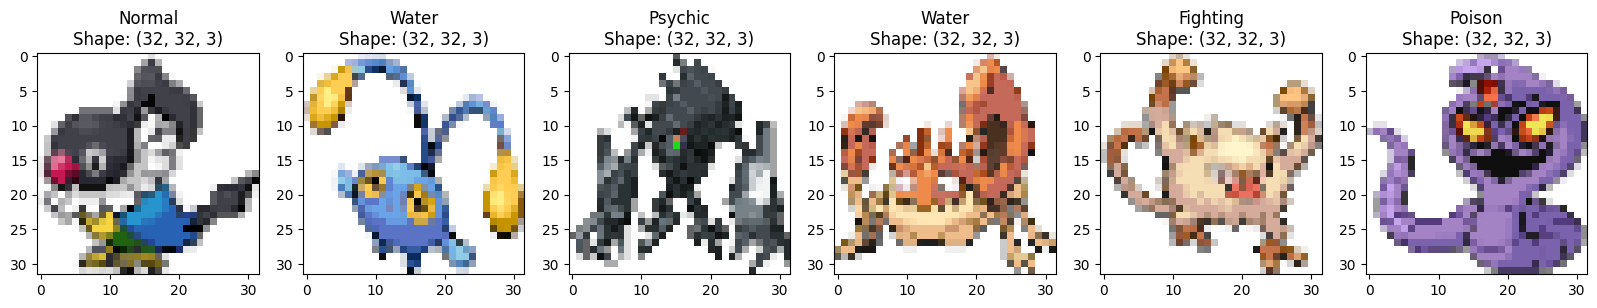

2024-06-06 18:16:14.197988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 32, 32, 3)
(64, 18)


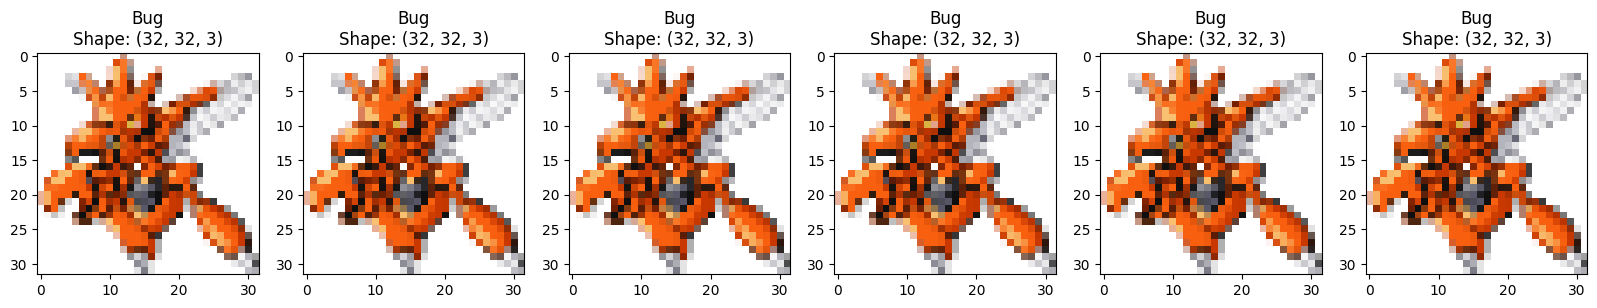

2024-06-06 18:16:14.576284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-06 18:16:14.577376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# get one batch of the dataset
dataset_example = poke_dataset.take(1)

# get one specific image of the batch
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

# expand the items to the batch size
img_example = np.expand_dims(img_example, axis=0)
label_example = np.expand_dims(label_example, axis=0)

dataset_overfitting = tf.data.Dataset.from_tensor_slices((img_example, label_example))

n_images = len(poke_dataset) * BATCH_SIZE
dataset_overfitting = dataset_overfitting.repeat(n_images).batch(BATCH_SIZE)

for img, label in dataset_overfitting:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_overfitting.take(1):
    label_example = label[0]
    visualize.plot_images_batch(dataset_tf=dataset_overfitting)

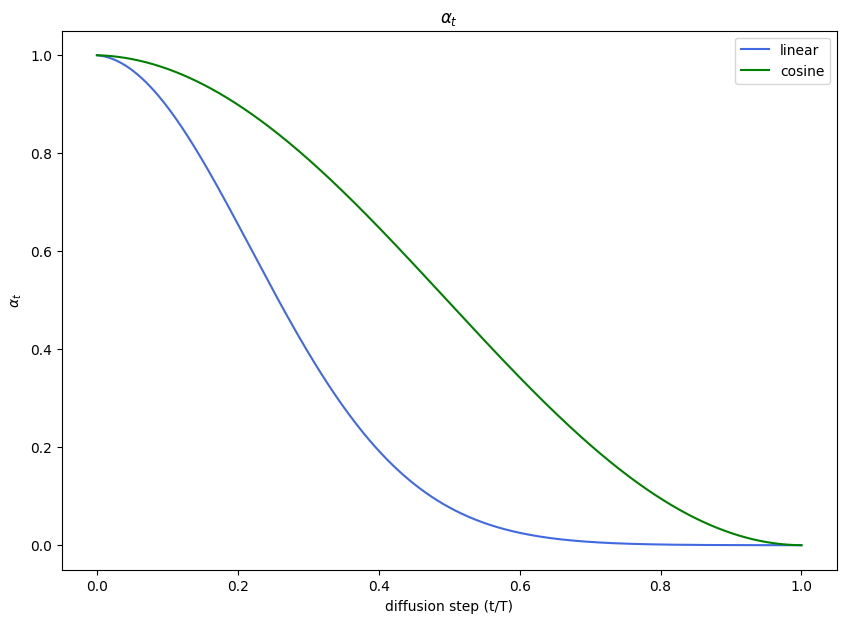

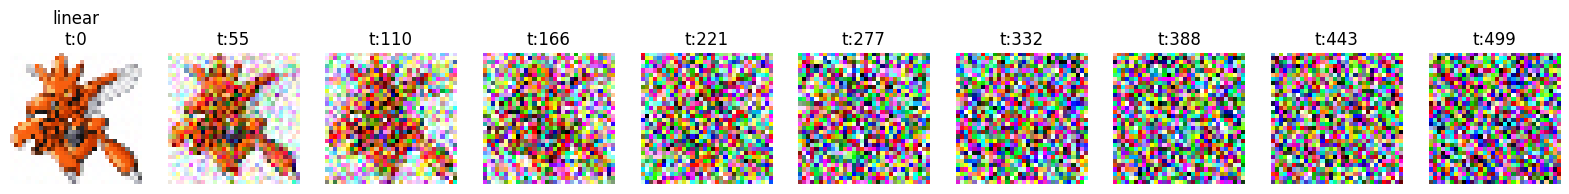

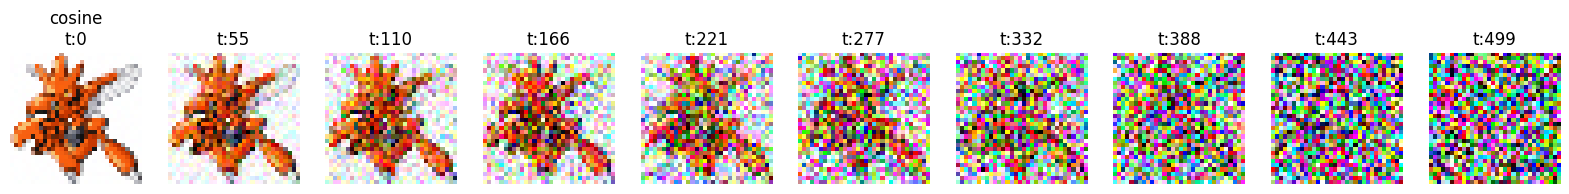

In [6]:
# Plot all the noise levels in the same plot
# =====================================================================
visualize.plot_noise_levels(TIMESTEPS, BETA_START, BETA_END, S)

# Plot the forward diffusion function
# =====================================================================
X_train = dataset_overfitting.map(lambda x, y: x)  # Get the images from the dataset
random_image = next(iter(X_train))[random.randint(0, BATCH_SIZE)]

visualize.plot_forward_diffusion(
    random_image, "linear", 10, TIMESTEPS, BETA_START, BETA_END, S
)
visualize.plot_forward_diffusion(
    random_image, "cosine", 10, TIMESTEPS, BETA_START, BETA_END, S
)

In [7]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, TIMESTEPS, BETA_START, BETA_END, S, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer, metrics=["mae"])

Epoch 1/100


I0000 00:00:1717697789.747306    3311 service.cc:145] XLA service 0x7cdf980148c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717697789.747325    3311 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-06 18:16:30.163396: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1717697790.628012    3311 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
2024-06-06 18:16:31.549437: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-06-06 18:16:38.089890: W external/local_tsl/tsl/framework/bfc_allocator.cc:368] Garbage collection: deallocate free memory regions (i.e., allocations

 1/63 ━━━━━━━━━━━━━━━━━━━━ 30:15 29s/step - mae: 1.2676 - loss: 2.5082

I0000 00:00:1717697807.080416    3311 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - mae: 0.8473 - loss: 1.1650
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.5289 - loss: 0.4714
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.4061 - loss: 0.3005
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - mae: 0.3705 - loss: 0.2623
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - mae: 0.3408 - loss: 0.2264
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - mae: 0.3214 - loss: 0.2055
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - mae: 0.3030 - loss: 0.1864
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - mae: 0.2921 - loss: 0.1769
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - mae: 0.2746 - loss: 0.1590
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - mae: 0.2639 - loss: 0.1509
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - mae: 0.2537 - loss: 0.1391
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - mae: 0.2427 - loss: 0.1296
Epoch 13/100
63/63 ━━━━━

Sampling sprite...: 100%|██████████| 499/499 [00:48<00:00, 10.23it/s]


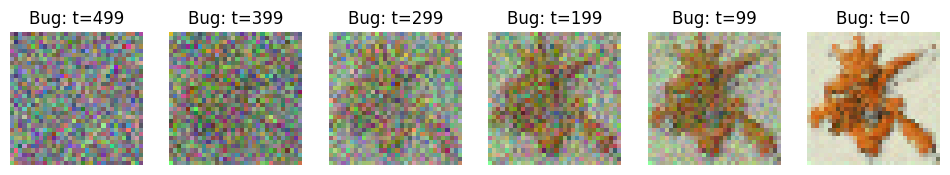

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 903ms/step - mae: 0.1791 - loss: 0.0729
Epoch 21/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - mae: 0.1829 - loss: 0.0760
Epoch 22/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - mae: 0.1693 - loss: 0.0657
Epoch 23/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - mae: 0.1650 - loss: 0.0616
Epoch 24/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - mae: 0.1596 - loss: 0.0576
Epoch 25/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - mae: 0.1515 - loss: 0.0520
Epoch 26/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - mae: 0.1458 - loss: 0.0494
Epoch 27/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - mae: 0.1419 - loss: 0.0469
Epoch 28/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - mae: 0.1431 - loss: 0.0471
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - mae: 0.1347 - loss: 0.0429
Epoch 30/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - mae: 0.1274 - loss: 0.0372
Epoch 31/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - mae: 0.1336 - loss: 0.0416
Epoch 32/100
63/

Sampling sprite...: 100%|██████████| 499/499 [00:49<00:00, 10.12it/s]


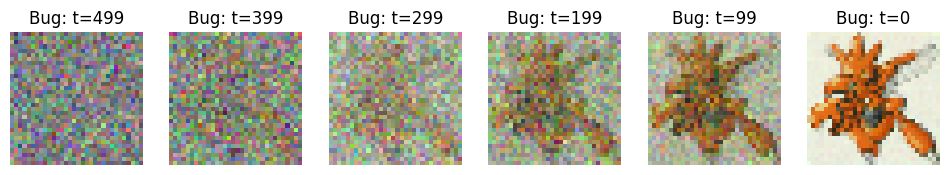

63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 914ms/step - mae: 0.1013 - loss: 0.0240
Epoch 41/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - mae: 0.1018 - loss: 0.0243
Epoch 42/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - mae: 0.1022 - loss: 0.0264
Epoch 43/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - mae: 0.0964 - loss: 0.0223
Epoch 44/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - mae: 0.1021 - loss: 0.0256
Epoch 45/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - mae: 0.1048 - loss: 0.0285
Epoch 46/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - mae: 0.0930 - loss: 0.0203
Epoch 47/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - mae: 0.0942 - loss: 0.0221
Epoch 48/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - mae: 0.0937 - loss: 0.0213
Epoch 49/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - mae: 0.0954 - loss: 0.0235
Epoch 50/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - mae: 0.0898 - loss: 0.0197
Epoch 51/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - mae: 0.0880 - loss: 0.0186
Epoch 52/100
63/

Sampling sprite...: 100%|██████████| 499/499 [00:49<00:00, 10.12it/s]


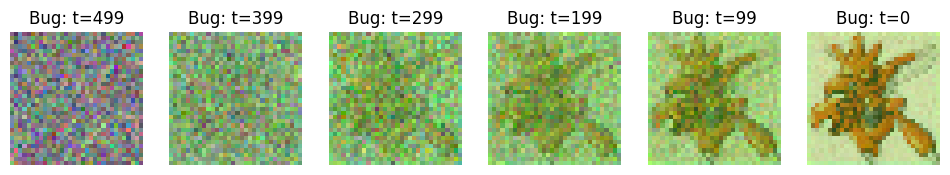

63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 916ms/step - mae: 0.0800 - loss: 0.0153
Epoch 61/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - mae: 0.0796 - loss: 0.0154
Epoch 62/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - mae: 0.0857 - loss: 0.0190
Epoch 63/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - mae: 0.0849 - loss: 0.0184
Epoch 64/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - mae: 0.0773 - loss: 0.0155
Epoch 65/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - mae: 0.0769 - loss: 0.0158
Epoch 66/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - mae: 0.0762 - loss: 0.0144
Epoch 67/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - mae: 0.0791 - loss: 0.0164
Epoch 68/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - mae: 0.0886 - loss: 0.0188
Epoch 69/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - mae: 0.0753 - loss: 0.0142
Epoch 70/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - mae: 0.0734 - loss: 0.0133
Epoch 71/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - mae: 0.0730 - loss: 0.0121
Epoch 72/100
63/

Sampling sprite...: 100%|██████████| 499/499 [00:51<00:00,  9.77it/s]


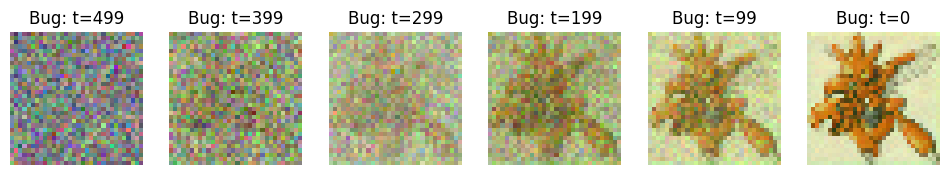

63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 947ms/step - mae: 0.0751 - loss: 0.0155
Epoch 81/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - mae: 0.0698 - loss: 0.0127
Epoch 82/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - mae: 0.0789 - loss: 0.0151
Epoch 83/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - mae: 0.0739 - loss: 0.0138
Epoch 84/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - mae: 0.0696 - loss: 0.0130
Epoch 85/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - mae: 0.0687 - loss: 0.0112
Epoch 86/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - mae: 0.0756 - loss: 0.0149
Epoch 87/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - mae: 0.0663 - loss: 0.0112
Epoch 88/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - mae: 0.0701 - loss: 0.0123
Epoch 89/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - mae: 0.0653 - loss: 0.0109
Epoch 90/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - mae: 0.0743 - loss: 0.0147
Epoch 91/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - mae: 0.0666 - loss: 0.0113
Epoch 92/100
63/

Sampling sprite...: 100%|██████████| 499/499 [00:50<00:00,  9.79it/s]


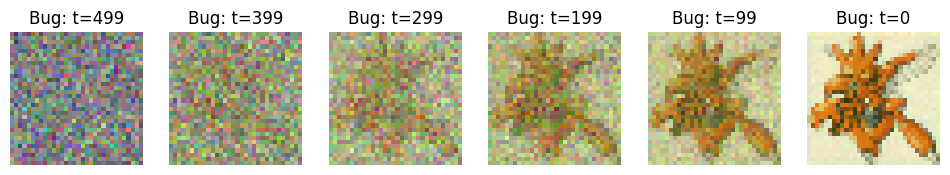

63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 946ms/step - mae: 0.0642 - loss: 0.0104


In [8]:
diff_callback = DiffusionCallback(model, 20, onehot_to_string(label_example))
model.fit(dataset_overfitting, epochs=EPOCHS, callbacks=[diff_callback])

Generating sample 1/6


Sampling sprite...: 100%|██████████| 499/499 [00:44<00:00, 11.24it/s]


Generating sample 2/6


Sampling sprite...: 100%|██████████| 499/499 [00:44<00:00, 11.22it/s]


Generating sample 3/6


Sampling sprite...: 100%|██████████| 499/499 [00:45<00:00, 11.08it/s]


Generating sample 4/6


Sampling sprite...: 100%|██████████| 499/499 [00:45<00:00, 11.02it/s]


Generating sample 5/6


Sampling sprite...: 100%|██████████| 499/499 [00:45<00:00, 10.96it/s]


Generating sample 6/6


Sampling sprite...: 100%|██████████| 499/499 [00:46<00:00, 10.82it/s]


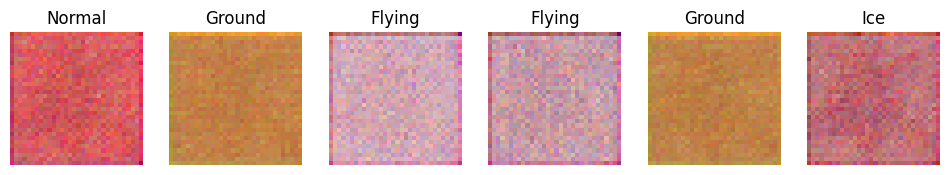

In [10]:
model.plot_samples(6)

Generating sample 1/1


Sampling sprite...: 100%|██████████| 499/499 [00:45<00:00, 10.99it/s]


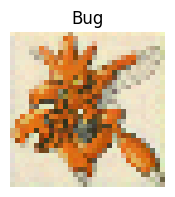

In [11]:
model.plot_samples(1, "Bug")